I often work with time-series data obtained from multiple sensors with irregular data acquisition rates. One of the most common problems is how to appropriately time-align the data, as any multivariate analytical method will typically require that the signals be mapped to the same time scale. The issue is made even more difficult due to a quirk of a third-party data historian I sometimes work with, which compresses data by removing repeated data points in the time-domain.

This blog series is intended to demonstrate the preprocessing algorithm developed to deal with data stored under these circumstances. In **Part 1**, I’ll establish motivation and explain the data compression algorithm itself. In **Part 2**, I'll run a Markov state model simulation meant to illustrate the consequences of using improperly prepared data. In **Part 3**, I’ll summarize the correct preprocessing algorithm and how it is easily implemented using the Python library **pandas**.

The data compression algorithm used in the historian is as follows, per variable, per time step:
* Is the value at the current time the same as the last value written to the database?
   - If true, store nothing in the database.
   - If false, store the last written value in the previous time step, and the current value in the current time step.

Data is pulled from the historian "*raw*", which means that it is already compressed and must be expanded to its original form before analysis. This requirement is not clearly stated in the data historian documentation, and initial models produced inaccurate results because the data was not properly expanded before model construction.

In theory, the *compressed* data from the algorithm above can be fully restored by forward-filling all missing data points. In practice, sensor communication drops caused data gaps which looked exactly the same as *compressed* data. Detecting these communication drops involved a more extensive solution which may be described in a subsequent post.

The following Python code and figure demonstrates how the compression algorithm works in practice, assuming a signal resolution of 1.0 units.

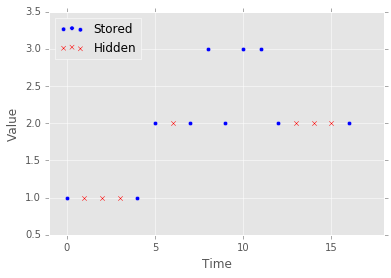

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
#'s' represents stored data, 'h' represents hidden data
sig = pd.DataFrame(data={'Time':range(17),
                         'Value':[1,1,1,1,1,2,2,2,3,2,3,3,2,2,2,2,2],
                         'Flag':['s','h','h','h','s','s','h','s','s',
                                 's','s','s','s','h','h','h','s']})
plt.figure(0)
#Plot the stored data as blue dots
ax = sig[sig['Flag'] == 's'].plot(x='Time',y='Value',c='b',
                                  kind='scatter',label='Stored')
#Plot the hidden data as red Xs
sig[sig['Flag'] == 'h'].plot(x='Time',y='Value',c='r',marker='x',
                             kind='scatter',label='Hidden',ax=ax)
#Adjust the axis and legend
ax.legend(loc='upper left')
plt.axis([-1,18,0.5,3.5]);

Note that time periods which are relatively stationary (e.g. times 0-4 in the above figure) will be compressed more heavily than time periods where the value changes often (e.g. times 7-12 in the above figure). Furthermore, sensor output resolution affects the compression rate. Imagine if the step size was 0.5 units in the above figure rather than 1.0 units- some of the "hidden" values might be shifted by 0.5 units, which means they might be stored more often.

Before I began working at the company, some analysts believed that the missing data was due to the sensor acquisition rate itself. To preprocess their data, they would attempt to time-align data only when sensor timestamps matched exactly. The following figure demonstrates why this is a poor practice, using a plot of *raw* data from two sensors.

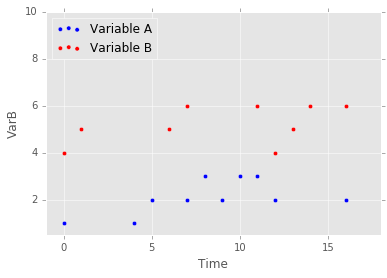

In [2]:
sig2 = pd.DataFrame(data={'Time':range(17),
                          'VarA':[1,None,None,None,1,2,None,2,3,2,3,3,2,None,None,None,2],
                          'VarB':[4,5,None,None,None,None,5,6,None,None,None,6,4,5,6,None,6]})
plt.figure(1)
#Plot 'raw' Variable A using blue dots
ax = sig2.plot(x='Time',y='VarA',c='b',kind='scatter',label='Variable A')
#Plot 'raw' Variable B using red dots
sig2.plot(x='Time',y='VarB',c='r',kind='scatter',label='Variable B',ax=ax)
#Adjust the axis and legend
ax.legend(loc='upper left')
plt.axis([-1,18,0.5,10]);                       

Very few of the data points in this example match exactly (5 out of 17). If the sensor acquisition rates are both 1 Hz, only 29.4% of the full dataset is being utilized by the faulty preprocessing algorithm. This effect becomes even greater when additional variables are time-aligned at once.

*Raw* data retrieved from the historian is not randomly sampled from the original distribution, as common values are removed more often than rare values. Hence, *raw* data from the historian is skewed towards the tail ends of the original distribution. The effects of this non-random sampling will be investigated in **Part 2**.